In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn import preprocessing, grid_search
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

from sklearn import neighbors
from sklearn.neighbors import NearestNeighbors
from statsmodels.robust.scale import mad


In [19]:
n_neighbors = 20
n_feature_kept = 500
param_grid = {
}

In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')


In [4]:
# We're going to be building a 'TP53' classifier 
GENE = 'TP53'


In [ ]:
if not os.path.exists('data'):
    os.makedirs('data')


In [ ]:
url_to_path = {
    # X matrix
    'https://ndownloader.figshare.com/files/5514386':
        os.path.join('data', 'expression.tsv.bz2'),
    # Y Matrix
    'https://ndownloader.figshare.com/files/5514389':
        os.path.join('data', 'mutation-matrix.tsv.bz2'),
}

for url, path in url_to_path.items():
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)


In [5]:
%%time
path = os.path.join('data', 'expression.tsv.bz2')
X = pd.read_table(path, index_col=0)


Wall time: 3min 1s


In [6]:
%%time
path = os.path.join('data', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)


Wall time: 2min 34s


In [7]:
y = Y[GENE]


In [ ]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)


In [ ]:
# top samples
X.head(6)

In [ ]:
# Here are the percentage of tumors with NF1
y.value_counts(True)


# Set aside 10% of the data for testing

In [8]:
# Typically, this can only be done where the number of mutations is large enough
# limit X and y for faster testing
X_train, X_test, y_train, y_test = train_test_split(X[:3000], y[:3000], test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))


'Size: 20,501 features, 2,700 training samples, 300 testing samples'

## Create a pipeline to do the prediction

In [9]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

# select the top features with the highest MAD
feature_select = SelectKBest(fs_mad, k=n_feature_kept)

In [20]:
clf = neighbors.KNeighborsClassifier(n_neighbors,'uniform')
# clf = neighbors.KNeighborsClassifier(n_neighbors,'distance')

# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
pipeline = make_pipeline(
    feature_select,  # Feature selection
    StandardScaler(),  # Feature scaling
    clf_grid)

In [21]:
%%time
# Fit the model (the computationally intensive part)
pipeline.fit(X=X_train, y=y_train)
best_clf = clf_grid.best_estimator_
feature_mask = feature_select.get_support()  # Get a boolean array indicating the selected features


Wall time: 10.2 s


In [22]:
%%time
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)


Wall time: 11.1 s


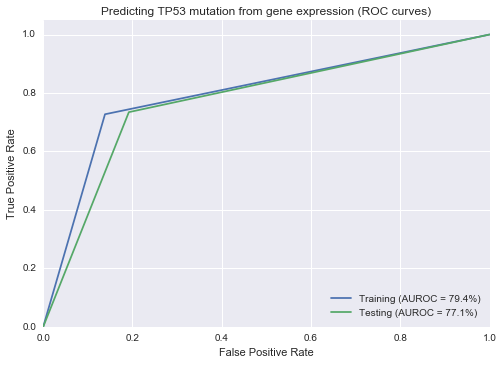

In [23]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');